In [2]:
# Importação dos pacotes.

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [3]:
# Carregar dados.
titanic = pd.read_pickle('/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Dados/aula4_titanic1.pkl')
X = titanic.drop(columns='survived')
y = titanic.survived

titanic.head()

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [4]:
# Dividir os dados em treino e teste (holdout).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [5]:
# Definir o espaço de hiperparâmetros para Random Forest.
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Número de árvores.
    'max_depth': range(2, 30, 1),      # Profundidade máxima das árvores.
    'min_samples_split': [2, 5, 10],      # Número mínimo de amostras para dividir um nó.
    'min_samples_leaf': [1, 2, 4],        # Número mínimo de amostras em uma folha.
    'max_features': ['sqrt', 'log2', None],  # Número de features consideradas para divisão.
    'bootstrap': [True, False],           # Usar bootstrap ou não.
    'criterion': ['gini', 'entropy'],     # Critério de divisão.
    'ccp_alpha': np.linspace(0, 0.05, 20)  # Parâmetro de poda de complexidade de custo.
}

param_dist

{'n_estimators': [50, 100, 200, 300],
 'max_depth': range(2, 30),
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['sqrt', 'log2', None],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'ccp_alpha': array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
        0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
        0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
        0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ])}

In [7]:
# Número de possibilidades.
4*30*3*3*3*2*2*20

259200

In [9]:
# Configurar o RandomizedSearchCV.
n_iter = 50  # Número de combinações de hiperparâmetros a serem testadas.
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold estratificado.
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=kf,
    scoring='roc_auc',
    n_jobs=-1,  # Usar todos os núcleos do processador.
    verbose=1,  # Mostrar progresso.
    random_state=42
)

random_search

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
       0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
       0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
       0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 30),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [10]:
# Executar o RandomizedSearchCV no conjunto de treino.
# Iniciar o cronômetro.
start_time = time.time()
random_search.fit(X_train, y_train)
# Parar o cronômetro.
end_time = time.time()
elapsed_time = end_time - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [11]:
# Resultados da busca.
print(f"\nMelhores hiperparâmetros: {random_search.best_params_}")
print(f"\nAUC média na validação cruzada: {random_search.best_score_:.4f}")
print(f"\nTempo total de execução: {elapsed_time:.2f} segundos")


Melhores hiperparâmetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': 0.018421052631578946, 'bootstrap': False}

AUC média na validação cruzada: 0.8699

Tempo total de execução: 50.19 segundos


In [12]:
# Treinar o modelo final com os melhores hiperparâmetros.
final_clf = random_search.best_estimator_

# Avaliar no conjunto de teste.
random_test_score = final_clf.score(X_test, y_test)
random_roc = roc_auc_score(y_test, final_clf.predict_proba(X_test)[:,1])
random_gini = random_roc*2-1
print(f"Gini do random search no teste: {random_gini:.4f}")

Gini do random search no teste: 0.7099


In [14]:
# Resgatando a árvore do script anterior.

# Carregar o modelo salvo.
with open('arvore_final.pkl', 'rb') as file:
    arvore_final = pickle.load(file)

arvore_final

DecisionTreeClassifier(ccp_alpha=0.003962354912878935, max_depth=5,
                       random_state=42)

In [15]:
# Verificar se o modelo suporta predict_proba (caso contrário, usar a decisão bruta).
if hasattr(arvore_final, "predict_proba"):
    y_scores = arvore_final.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva.
else:
    y_scores = arvore_final.decision_function(X_test)  # Alternativa se não houver predict_proba.

# Calcular a AUC.
auc_score = roc_auc_score(y_test, y_scores)
gini = auc_score*2-1
print(f"gini na base de teste da árvore: {gini:.4f}")

gini na base de teste da árvore: 0.7546


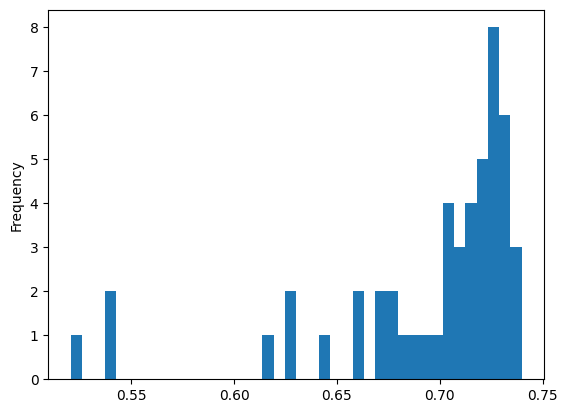

In [16]:
# Avaliando os resultados do tunning.
resultados = pd.DataFrame(random_search.cv_results_)
resultados['gini'] = resultados.mean_test_score*2-1
resultados.gini.plot.hist(bins=40)
plt.show()

In [18]:
# Bayesian search.
param_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy']),
    'ccp_alpha': Real(0, 0.05)
}

n_iter=20
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces=param_space,
    n_iter=n_iter,  # Número de iterações
    cv=5,       # 5-Fold Cross-Validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              n_iter=20, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'ccp_alpha': Real(low=0, high=0.05, prior='uniform', transform='identity'),
                             'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Int...='uniform', transform='identity'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=1, high=4, prior='uniform', transform='identity'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='identity')},
              verbose=1)

In [19]:
# Executar o RandomizedSearchCV no conjunto de treino.
# Iniciar o cronômetro.
start_time = time.time()
bayes_search.fit(X_train, y_train)
# Parar o cronômetro.
end_time = time.time()
elapsed_time = end_time - start_time

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [20]:
# Resultados da busca.
print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")
print(f"\nAUC média na validação cruzada: {bayes_search.best_score_:.2%}")
print(f"\nTempo total de execução: {elapsed_time:.2f} segundos")

Melhores hiperparâmetros: OrderedDict([('bootstrap', False), ('ccp_alpha', 0.005162311544715185), ('criterion', 'gini'), ('max_depth', 32), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 108)])

AUC média na validação cruzada: 87.16%

Tempo total de execução: 50.51 segundos


In [21]:
# Treinar o modelo final com os melhores hiperparâmetros.
final_clf = bayes_search.best_estimator_

# Avaliar no conjunto de teste.
bayes_test_score = final_clf.score(X_test, y_test)
bayes_roc = roc_auc_score(y_test, final_clf.predict_proba(X_test)[:,1])
bayes_gini = bayes_roc*2-1
print(f"Gini do bayesian search no teste: {bayes_gini:.4f}")

Gini do bayesian search no teste: 0.7190


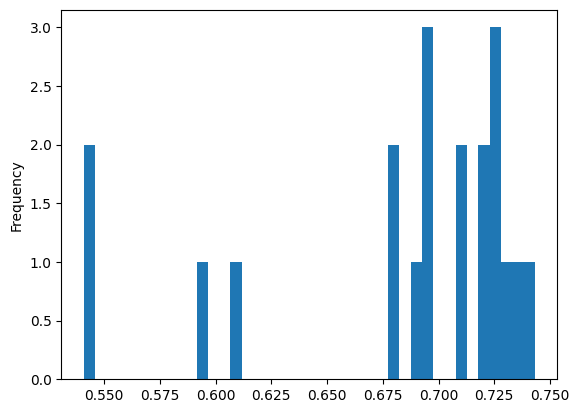

In [22]:
# Resultado final.
resultados_bayes = pd.DataFrame(bayes_search.cv_results_)
resultados_bayes['gini'] = resultados_bayes.mean_test_score*2-1
resultados_bayes.gini.plot.hist(bins=40)
plt.show()